# Hello this is a CNN
I am doing it

### Importing the Data

In [1]:
import pickle

with open('assets/fold5_df.pkl', 'rb') as f:
    conv_data = pickle.load(f)
f.close()


## Structure

We will have 4 separated convolutional networks, three for the 2D features and another to the 1D data, that will be flattened and concatenated into a MLP

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.python.client import device_lib
import pandas as pd

### Model

Features & Shapes:

- 2D Chromagram: (12, 321)
- 2D Mel Spectogram: (128, 321)
- 2D Fourier Tempogram: (508, 322)
- 1D Features: (40)

#### Chromagram Layer

In [3]:
chromagram_shape = (12, 321, 1)

chromagram_input = keras.Input(shape=chromagram_shape, name='chromagram_input')

chromalayer = layers.Conv2D(64, (4,4), activation='relu')(chromagram_input)
# chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromalayer)
chromalayer = layers.MaxPooling2D((2,2))(chromalayer)
chromalayer = layers.Dropout(0.2)(chromalayer)
# chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromalayer)
chromalayer = layers.Flatten()(chromalayer)

#### Mel Spectrogram Layer

In [4]:
mel_shape = (128, 321, 1)

mel_spectogram_input = keras.Input(shape=mel_shape, name='mel_spectogram_input')

mellayer = layers.Conv2D(64, (3,3), activation='relu')(mel_spectogram_input)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.3)(mellayer)
mellayer = layers.Conv2D(32, (3,3), activation='relu')(mellayer)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.3)(mellayer)
mellayer = layers.Flatten()(mellayer)

#### Fourier Tempogram Layer

In [5]:
tempogram_shape = (508, 322, 1)

fourier_tempogram = keras.Input(shape=tempogram_shape, name='fourier_tempogram')

fourierlayer = layers.Conv2D(128, (3,3), activation='relu')(fourier_tempogram)
fourierlayer = layers.MaxPooling2D((3,3))(fourierlayer)
fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.MaxPooling2D((3,3))(fourierlayer)	
fourierlayer = layers.Dropout(0.3)(fourierlayer)
fourierlayer = layers.Conv2D(32, (3,3), activation='relu')(fourierlayer)
# fourierlayer = layers.Dropout(0.4)(fourierlayer)
# fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.Flatten()(fourierlayer)

#### 1D Features Layer

In [6]:
features_1d_shape = (321, 4)

features_1d = keras.Input(shape=features_1d_shape, name='features_1d')

featureslayer = layers.Conv1D(32, 3, activation='relu')(features_1d)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Dropout(0.2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.Flatten()(featureslayer)


#### Combined Layers

In [7]:
combined = layers.concatenate([chromalayer, fourierlayer, mellayer, featureslayer])
combined = layers.Dense(128, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(64, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(32, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(10, activation='softmax')(combined)

model = keras.Model(inputs=[chromagram_input, mel_spectogram_input, fourier_tempogram, features_1d], outputs=combined)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fourier_tempogram (InputLa  [(None, 508, 322, 1)]        0         []                            
 yer)                                                                                             
                                                                                                  
 mel_spectogram_input (Inpu  [(None, 128, 321, 1)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 features_1d (InputLayer)    [(None, 321, 4)]             0         []                            
                                                                                              

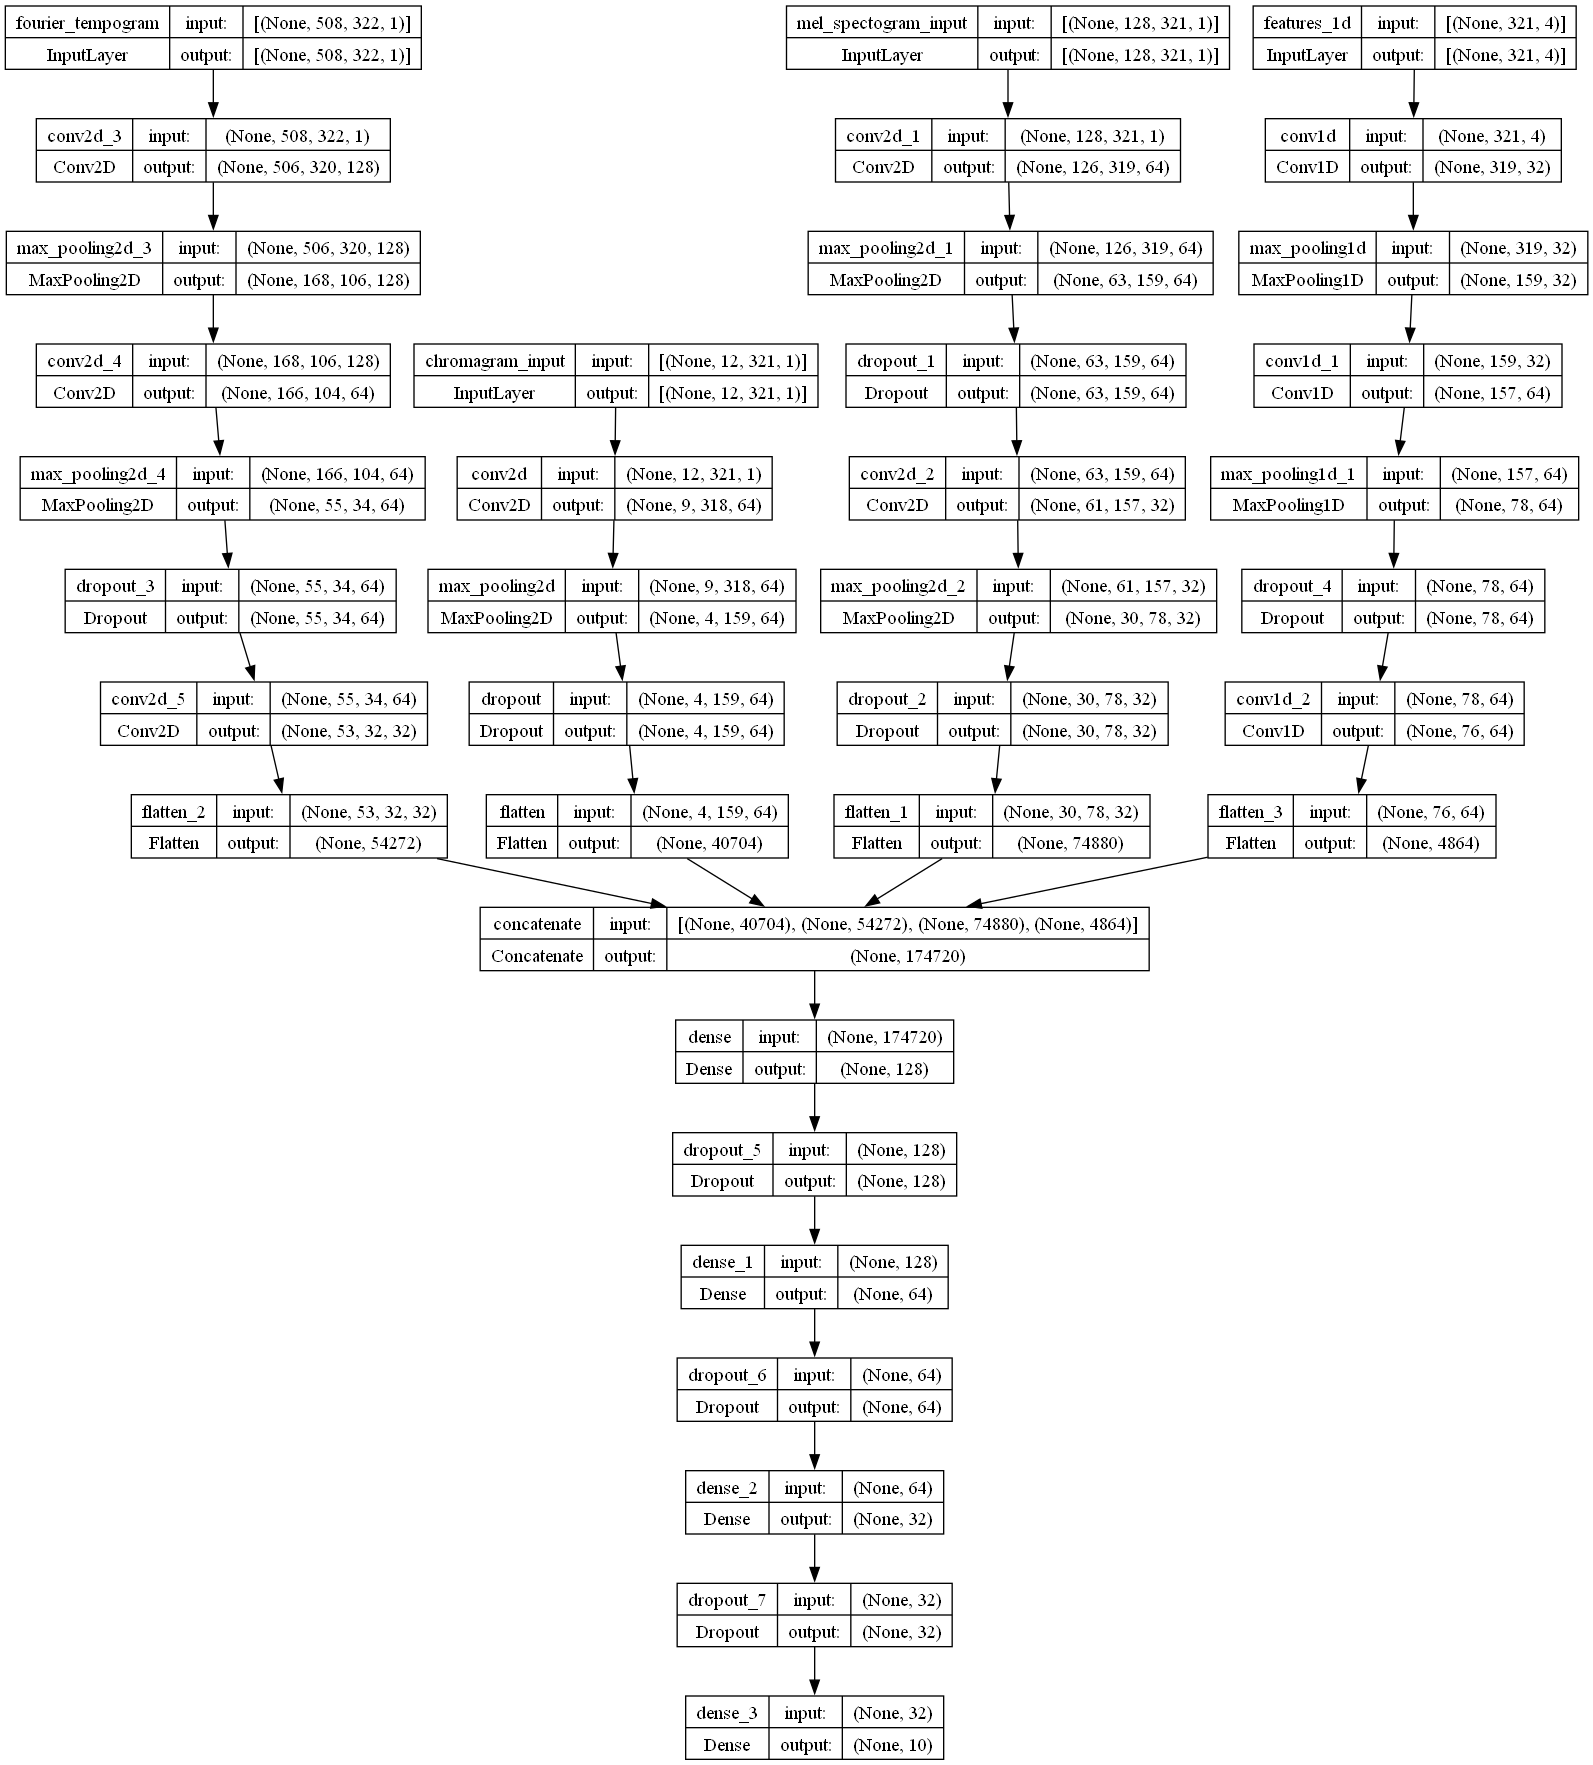

In [8]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### Creating the target class

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

X = conv_data.drop(columns=['slice_file_name','classID'])
y = conv_data['classID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=conv_data['classID'])
X_train , X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

#### Separating the test train into the respective layer inputs

In [10]:
def reshape_data(traindata):
    train_chroma = np.asarray(tuple(traindata["chromagram"].to_list())).astype(np.float32)
    train_mel = np.asarray(tuple(traindata["mel_spectogram"].to_list())).astype(np.float32)
    train_fourier = np.asarray(tuple(traindata["fourier_tempogram"].to_list())).astype(np.float32)
    train_1d = traindata.drop(columns=['chromagram','mel_spectogram','fourier_tempogram'])
    
    a = np.asarray(tuple(train_1d["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(train_1d["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(train_1d["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(train_1d["spectral_rolloff"].to_list())).astype(np.float32)

    train_1d = np.stack([a,b,c,d], axis=-1)

    train_1d = train_1d.reshape(-1, 321, 4)

    train_chroma = np.array([np.array(val) for val in train_chroma])
    train_mel = np.array([np.array(val) for val in train_mel])
    train_fourier = np.array([np.array(val) for val in train_fourier])

    return train_chroma, train_mel, train_fourier, train_1d

In [11]:
X_train_chroma, X_train_mel, X_train_fourier, X_train_1d = reshape_data(X_train)
X_test_chroma, X_test_mel, X_test_fourier, X_test_1d = reshape_data(X_test)
X_val_chroma, X_val_mel, X_val_fourier, X_val_1d = reshape_data(X_val)

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

a = model.fit(
    x={'features_1d': X_train_1d, 'chromagram_input': X_train_chroma, 'mel_spectogram_input': X_train_mel, 'fourier_tempogram': X_train_fourier},
    y=np.asarray(tuple(y_train.to_list())).astype(np.float32),
    validation_data=({'features_1d': X_val_1d, 'chromagram_input': X_val_chroma, 'mel_spectogram_input': X_val_mel, 'fourier_tempogram': X_val_fourier}, np.asarray(tuple(y_val.to_list())).astype(np.float32)),
    epochs=25,
    batch_size=65
)


Epoch 1/25


8/8 [==============================] - 286s 34s/step - loss: 2.6729 - accuracy: 0.0873 - val_loss: 2.2716 - val_accuracy: 0.2081
Epoch 2/25
8/8 [==============================] - 182s 23s/step - loss: 2.3219 - accuracy: 0.1179 - val_loss: 2.2284 - val_accuracy: 0.2487
Epoch 3/25
8/8 [==============================] - 203s 25s/step - loss: 2.1313 - accuracy: 0.2118 - val_loss: 1.8052 - val_accuracy: 0.3604
Epoch 4/25
8/8 [==============================] - 170s 22s/step - loss: 1.9504 - accuracy: 0.2926 - val_loss: 1.7189 - val_accuracy: 0.4822
Epoch 5/25
8/8 [==============================] - 156s 20s/step - loss: 1.7215 - accuracy: 0.4061 - val_loss: 1.5026 - val_accuracy: 0.5279
Epoch 6/25
8/8 [==============================] - 149s 19s/step - loss: 1.6210 - accuracy: 0.4716 - val_loss: 1.3474 - val_accuracy: 0.5939
Epoch 7/25
8/8 [==============================] - 176s 21s/step - loss: 1.5282 - accuracy: 0.4694 - val_loss: 1.3012 - val_accuracy: 0.6345
Epoch 8/25
8/8 [=

## Model Analysis

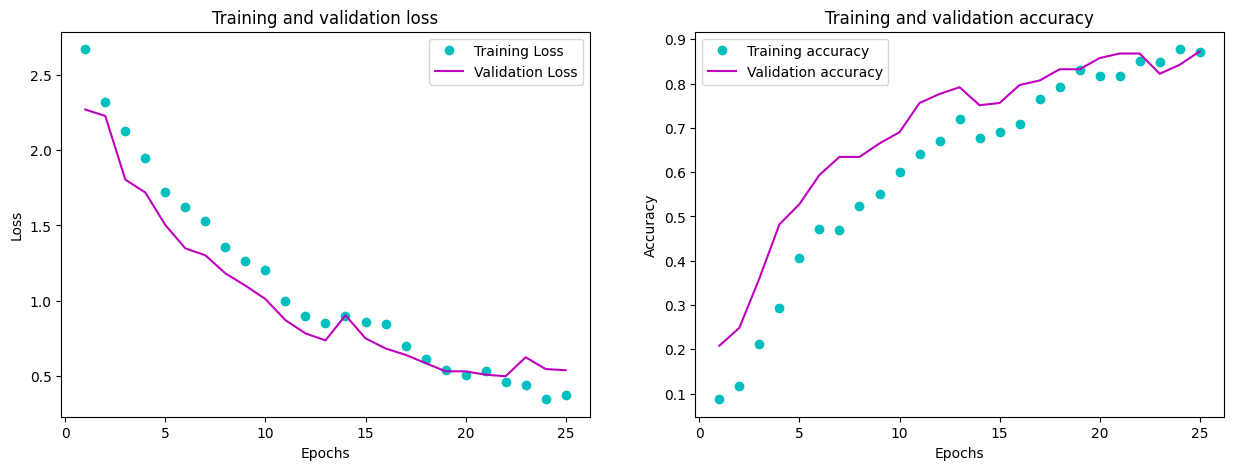

In [13]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
import matplotlib.pyplot as plt

history_dict = a.history

loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']

epochs = range(1,26)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()